In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch import nn
import torch.nn.init as init
from torch import optim
import torch

This part contains all the functions used for the preprocessing step.

In [2]:
def load_data(filepath):
    
    return pd.read_csv(filepath)

def clean_data(df):
    df.dropna(subset = ['y'], inplace = True)
    df.drop(['contact', 'poutcome', 'duration'], axis = 1, inplace=True) # these features have too many non values 
    df.dropna(inplace=True) # others
    for column in df.columns:

        if pd.api.types.is_numeric_dtype(df[column]):
        
            if column not in ['previous', 'pdays']:

                Q1 = df[column].quantile(0.25)
                Q3 = df[column].quantile(0.75)
                IQR = Q3 - Q1
                lower = Q1 - 1.5*IQR
                upper = Q3 + 1.5*IQR
                upper_array = np.where(df[column] >= upper)[0]
                lower_array = np.where(df[column] <= lower)[0]
                upper_array = [idx for idx in upper_array if idx in df.index]
                lower_array = [idx for idx in lower_array if idx in df.index]
                df = df[(df[column] >= lower) & (df[column] <= upper)]
    return df

def encode_data(df):

    df_encoded = df.replace(['yes', 'no'], [1, 0])
    
    df_encoded.replace(['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], 
                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], inplace=True)
    
    df_encoded = one_hot_encode(df_encoded, 'job')

    df_encoded = one_hot_encode(df_encoded, 'education')

    df_encoded = one_hot_encode(df_encoded, 'marital')

    return df_encoded

def one_hot_encode(df, column_name):
    if column_name in df.columns:

        df_encoded = pd.get_dummies(df[column_name], prefix=column_name, dtype=int)

        df.drop(column_name, axis=1, inplace=True)

        df = pd.concat([df, df_encoded], axis=1)

        print("One-hot encoding applied to column ", column_name, " successfully.")

        return df

    else:

        print(f"Column '{column_name}' not found in the DataFrame.")
    
    return df

This part contains functions for feature extraction like scaling data and dimension reduction.

In [3]:
def scale_features(df):

    # apply normalization 
    std_scaler = StandardScaler()

    df_scaled = std_scaler.fit_transform(df.drop('y', axis=1).values)

    df_scaled = pd.DataFrame(df_scaled, columns=df.drop('y', axis=1).columns)

    df_scaled['y'] = df['y']

    df_scaled.index = df.index

    return df_scaled

def reduce_dimensions(df):

    # Select samples, transform and reduce features
    df_reduced = pd.concat([df[df['y'] == 1].head(4000).reset_index(drop=True),
                                df[df['y'] == 0].tail(4000).reset_index(drop=True)],
                                ignore_index=False).sort_index(kind='merge')

    dim_red = PCA()

    x_pca = dim_red.fit_transform(df_reduced.drop('y', axis=1))

    training_features = ['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 'pca10', 'pca11', 'pca12', 'pca13']

    df_pca = pd.DataFrame(x_pca, columns=dim_red.get_feature_names_out())

    df_pca_working_set = df_pca[training_features]

    df_pca_working_set = df_pca_working_set.reset_index(drop=True)

    df_pca_working_set['y'] = df_reduced.reset_index(drop=True)['y']

    return df_pca_working_set

This is the model used for training the neural network.

In [4]:
class NeuralNetwork(nn.Module):

    def __init__(self):

        super(NeuralNetwork, self).__init__()

        self.layers = nn.Sequential(

            nn.Linear(14, 32),

            nn.ReLU(),

            nn.Linear(32, 16),

            nn.ReLU(),

            nn.Linear(16, 1),

            nn.Sigmoid()

        )

        self._initialize_weights()

    def _initialize_weights(self):

        for m in self.modules():

            if isinstance(m, nn.Linear):

                init.kaiming_normal_(m.weight)

    def forward(self, inputs):

        return self.layers(inputs)



The data are split into training and testing data. 1000 samples are used for testing and 7000 for training. The data are chosen so that the imbalance is minimized. The data contain 4000 samples with target value of 'no' and 4000 with target value of 'yes'.


In [5]:
def split_data(df):

    x_tensor = torch.tensor(df.drop(columns=['y']).tail(7000).values, dtype=torch.float32)

    y_tensor = torch.tensor(df['y'].tail(7000).values, dtype=torch.float32)

    dataset = torch.utils.data.TensorDataset(x_tensor, y_tensor)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size = 64)

    x_test_tensor = torch.tensor(df.drop(columns=['y']).head(1000).values, dtype=torch.float32)

    y_test_tensor = torch.tensor(df['y'].head(1000).values, dtype=torch.float32)

    test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 8)

    return train_loader, test_loader

Based on the experiments, the number of epichs was determined to be 3000. To minimize the loss, the learning rate is reduced during the training process. The weights of the output are manipulated to prevent the model being biased to the 0 class.

In [6]:
EPOCHS = 3000
LEARNING_RATE = .001

def train(model, train_loader):
    
    learning_rate = LEARNING_RATE
    
    optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
    
    cost = nn.MSELoss()

    for epoch in range(EPOCHS):

        total_training_loss = 0

        for i, data in enumerate(train_loader, 0):

            inputs, targets = data

            targets = targets.unsqueeze(1)

            optimizer.zero_grad()

            preds = model.forward(inputs)

            weight = torch.where(targets == 1, torch.tensor([1.0]), torch.tensor([0.02]))
            
            loss = cost(preds, targets) * weight
            
            loss = loss.mean()
            
            total_training_loss += loss.item()

            loss.backward()

            optimizer.step()

        if (epoch%500) == 0 and epoch != 0:
            
            learning_rate = learning_rate / 2
            
            for param in optimizer.param_groups:
            
                param['lr'] = learning_rate

        print(f'Epoch {epoch}. Learning Rate: {learning_rate} Total Training Loss: ', total_training_loss)

    return model

After training, the model's performance is evaluated using metrics such as confusion matrix, accuracy, precision, recall (sensitivity), specificity, and F1 score.

In [7]:
def extract_metrics(y_true, y_pred):
    
    cm = metrics.confusion_matrix(y_true, y_pred, labels=[1, 0])

    print(cm.T)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [1, 0])

    cm_display.plot()
    
    Accuracy = metrics.accuracy_score(y_true, y_pred) 
    
    Precision = metrics.precision_score(y_true, y_pred)

    Sensitivity_recall = metrics.recall_score(y_true, y_pred)

    Specificity = metrics.recall_score(y_true, y_pred, pos_label=0)

    F1_score = metrics.f1_score(y_true, y_pred)

    print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})
    
    plt.show()

def evaluate(model, test_loader):

    y_true = np.empty((0, ))

    y_pred = np.empty((0, ))

    for inputs, labels in test_loader:

            output = model(inputs)

            output = (output > 0.5).float()

            output = output.detach().cpu().numpy()

            y_pred = np.append(y_pred, output)

            labels = labels.detach().cpu().numpy()

            y_true =  np.append(y_true, labels) # Save Truth
    
    extract_metrics(y_true, y_pred)

One-hot encoding applied to column  job  successfully.
One-hot encoding applied to column  education  successfully.
One-hot encoding applied to column  marital  successfully.
Epoch 0. Learning Rate: 0.001 Total Training Loss:  9.21127376286313
Epoch 1. Learning Rate: 0.001 Total Training Loss:  8.21543651074171
Epoch 2. Learning Rate: 0.001 Total Training Loss:  7.554110895143822
Epoch 3. Learning Rate: 0.001 Total Training Loss:  7.249600376235321
Epoch 4. Learning Rate: 0.001 Total Training Loss:  7.028230243362486
Epoch 5. Learning Rate: 0.001 Total Training Loss:  6.848356295144185
Epoch 6. Learning Rate: 0.001 Total Training Loss:  6.68904207739979
Epoch 7. Learning Rate: 0.001 Total Training Loss:  6.564061771146953
Epoch 8. Learning Rate: 0.001 Total Training Loss:  6.455306798918173
Epoch 9. Learning Rate: 0.001 Total Training Loss:  6.35146923805587
Epoch 10. Learning Rate: 0.001 Total Training Loss:  6.2583561352221295
Epoch 11. Learning Rate: 0.001 Total Training Loss:  6.16

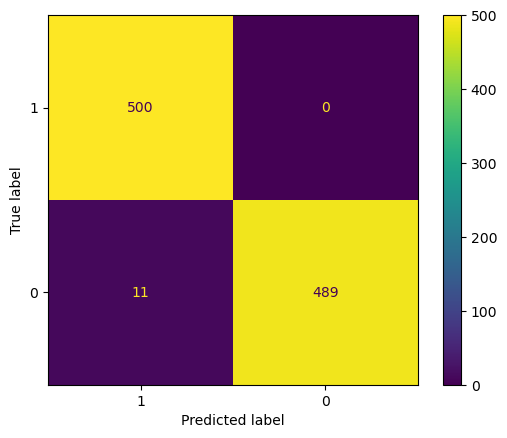

In [10]:
DATA_PATH = './data.csv'

# Step 1: preprocess the data
df = load_data(DATA_PATH)
df_cleaned = clean_data(df)
df_encoded = encode_data(df_cleaned)

# Step 2: Standarize and reduce dimensions
df_scaled = scale_features(df_encoded)
df_reduced = reduce_dimensions(df_scaled)

# Step 3: Create Classification Model
classifier = NeuralNetwork()

# Step 4: Train
train_loader, test_loader = split_data(df_reduced)
train(classifier, train_loader)

# Step 5: Test Model
evaluate(classifier, test_loader)